## DSTA

### Chapter V - Financial networks.

#### This __demonstration (no exercise)__ notebook is taken from the notebook for Ch. 5 of Caldarelli-Cheesa's textbook (CC).

Please see the [class repository](https://www.dcs.bbk.ac.uk/~ale/dsta/) for the datasets.

For local usage, it is recommended to install yfinance from within Anaconda, e.g.

```bash
C:\WINDOWS\system32>conda install -c ranaroussi yfinance
```
or from the Navigator tool, e.g. by subscribing to the "ranaroussi" channel.
Without Anaconda, you may install the package directly:

```bash
C:\WINDOWS\system32>pip install yfinance
```

In any case these commands are repeated below, please comment out as needed.

#### Changelog

This March 2023 version by P. Lagias runs on a reduced dataset of tickers to avoid issues with delisted/defunct stocks. 

In [ ]:
%pylab inline

In [ ]:
!pip install graphviz

In [ ]:
!pip install yfinance

In [ ]:
!pip install yahoofinancials

In [89]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
import math
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

from collections import Counter
from yahoofinancials import YahooFinancials
from yahoofinancials.etl import ManagedException

### Connecting with the Yahoo! Finance service

In [90]:
# Download data for 1 day as an example
data = yf.download("AAPL", start="2014-05-19", end="2014-05-20")
print(data)

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2014-05-19  21.351786  21.690357  21.333214  21.592501  19.227318  317755200


## Transaction volumes computation and plotting

In [91]:
# Now download the data for the entire 2019 year.
d = yf.download("MSFT", start="2019-01-01", end="2019-12-31")
d['Transaction_Volume'] = d['Volume'] * d['Adj Close']

print(d)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-01-02   99.550003  101.750000   98.940002  101.120003   96.632668   
2019-01-03  100.099998  100.190002   97.199997   97.400002   93.077736   
2019-01-04   99.720001  102.510002   98.930000  101.930000   97.406723   
2019-01-07  101.639999  103.269997  100.980003  102.059998   97.530930   
2019-01-08  103.040001  103.970001  101.709999  102.800003   98.238121   
...                ...         ...         ...         ...         ...   
2019-12-23  158.119995  158.119995  157.270004  157.410004  152.648911   
2019-12-24  157.479996  157.710007  157.119995  157.380005  152.619812   
2019-12-26  157.559998  158.729996  157.399994  158.669998  153.870773   
2019-12-27  159.449997  159.550003  158.220001  158.960007  154.152023   
2019-12-30  158.990005  159.020004  156.729

In [92]:
# Downloaded data are saved as a dataframe
type(d)

pandas.core.frame.DataFrame

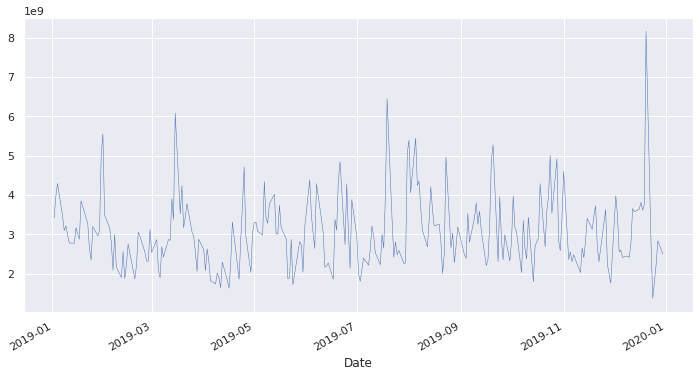

In [93]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize': (12, 6)})

d['Transaction_Volume'].plot(linewidth=0.5);

# Download NYSE tickers
### with all the information related to the market capitalization, sector and industry...
### (http://www.nasdaq.com/screening/company-list.aspx)

In [ ]:
!head companylist.csv 

## Get Stock Labels, Sector and Industries

In [ ]:
# Get stock data from the text file
f = open("list_stocks_50B_6_may_2016.txt", 'r')
list_stocks = []

while True:
    next_line = f.readline()
    if not next_line: break
    # print(next_line.split('\t'))
    list_stocks.append(tuple(next_line.split('\t')[:-1]))

f.close()

# a huge dump of all stocks, uncomment only if needed
for stock in list_stocks:
    print(stock)


In [ ]:
# This code must stay commented until fixed.

# # get values
# # May 6th 2016
# # greater than 50B$
# cap_threshold = 50_000_000_000
# hfile = open("companylist.csv", 'r')

# list_stocks = []
# nextline = hfile.readline()

# while True:
#     nextline = hfile.readline()
#     if not nextline:
#         break
        
#     line = nextline.split(',')
#     sym = line[0][1:-1]

#     # Skip entries with "^" in stock name
#     if sym.find("^") != -1:
#         continue

#     share = YahooFinancials(sym) # this cause an issue
#     y_market_cap = None

#     try:
#         y_market_cap = share.get_market_cap()
#     except:
#         y_market_cap = None
#         print(f"No link for {sym}")
#     # y_market_cap1=y_m
    
#     if not y_market_cap:
#         print(f"No market cap found for {sym}")
#         continue
    
#     # We will exclude stocks with char ’^’ that will
#     # give errors in the query process
#     if y_market_cap > cap_threshold:
#         print(sym, y_market_cap, line)
#         stock_data = (line[0][1:-1], line[1][1:-1], line[5][1:-1], line[6][1:-1])
#         list_stocks.append(stock_data)
#     time.sleep(1)

# hfile.close()
# print(list_stocks[0])

## Generate dictionaries for companies, sectors and colors

In [96]:
diz_sectors = {}
for s in list_stocks:
    # print(s)
    diz_sectors[s[0]] = s[2]

list_ranking = []

for s in set(diz_sectors.values()):
    count = 0
    for key in diz_sectors:
        if s in diz_sectors[key]:
            count += 1
    list_ranking.append((count,s))
    
list_ranking.sort(reverse=True)

# list_colors=['red','green','blue','black''cyan','magenta','yellow'] 
list_colors=['0.0', '0.2', '0.4', '0.6','0.7', '0.8', '0.9'] 

# 'white' is an extra color for 'n/a' and 'other' sectors
diz_colors={}

# association color and more represented sectors
for s in list_ranking:
    if s[1] == 'n/a': 
        diz_colors[s[1]] = 'white'
        continue
    if list_colors == []: 
        diz_colors[s[1]] = 'white'
        continue
    diz_colors[s[1]] = list_colors.pop(0)

print(list_ranking)

[(21, 'n/a'), (21, 'Finance'), (13, 'Energy'), (12, 'Health Care'), (9, 'Public Utilities'), (9, 'Capital Goods'), (8, 'Consumer Non-Durables'), (7, 'Basic Industries'), (6, 'Consumer Services'), (5, 'Technology'), (4, 'Miscellaneous'), (3, '1999'), (1, 'Transportation')]


## Retrieving historical data

In [97]:
diz_comp = {}
for s in list_stocks:
    print(s[0])
    
    #stock = yf.Ticker(s[0])
    #diz_comp[s[0]]=stock.history("1mo")
    diz_comp[s[0]] = yf.download((s[0]), start="2013-05-01", end="2014-05-31")

# create dictionaries of time series for each company

MMM
[*********************100%***********************]  1 of 1 completed
ABT
[*********************100%***********************]  1 of 1 completed
ABBV
[*********************100%***********************]  1 of 1 completed
ACN
[*********************100%***********************]  1 of 1 completed
AEB
[*********************100%***********************]  1 of 1 completed
AED
[*********************100%***********************]  1 of 1 completed
AEK
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AEK: No timezone found, symbol may be delisted
BABA
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BABA: Data doesn't exist for startDate = 1367380800, endDate = 1401508800
MO
[*********************100%***********************]  1 of 1 completed
ABEV
[*********************100%***********************]  1 of 1 completed
AXP
[*********************100%***********************]  1 of 1 completed
AIG
[*********************100%

In [98]:
diz_historical = {}

for k in list(diz_comp.keys()):
    tmp = diz_comp[k]
    diz_historical[k] = tmp['Close']
    """
    for e in diz_comp[k]:
        print(e)
        # string indices must be integers
        #diz_historical[k][e['Date']]=e['Close'] 
        #print(e)
        #diz_historical[k][e[0]]=e[4] 
    """

for k in list(diz_historical.keys()):
    print(k, len(diz_historical[k]))

MMM 273
ABT 273
ABBV 273
ACN 273
AEB 273
AED 273
AEK 0
BABA 0
MO 273
ABEV 273
AXP 273
AIG 273
BUD 273
AZN 273
T 273
SAN 273
BAC 273
BNS 273
BCS 273
BHP 273
BBL 0
BLK 273
BA 273
BP 273
BMY 273
BT 0
CX 273
CVX 273
LFC 0
CHL 0
SNP 0
C 273
CEO 273
KO 273
CL 273
CCV 0
COP 273
CVS 273
DHR 273
DEO 273
DOW 0
DUK 273
DD 273
LLY 273
EMC 273
E 273
EPD 273
XOM 273
F 273
GE 273
GSK 273
GS 273
TV 273
HDB 273
HD 273
HON 273
HSBC 273
HSEA 0
HSEB 140
INZ 0
ISF 0
IBM 273
ITUB 273
JPM 273
JNJ 273
LYG 273
LMT 273
LOW 273
MA 273
MCD 273
MDT 273
MRK 273
MTU 0
MS 273
NGG 273
NEE 273
NKE 273
NTT 0
NVS 273
NVO 273
DCM 0
OXY 273
ORCL 273
PEP 273
PTR 0
PFE 273
PM 273
PG 273
RAI 0
RIO 273
RY 273
SNY 273
SAP 273
SLB 273
SPG 273
STO 0
TSM 273
TEF 273
TMO 273
TWC 0
TWX 273
TJX 273
TD 273
TOT 0
TM 273
USB 273
UBS 273
UN 0
UL 273
UNP 273
UPS 273
UTX 0
VZ 273
VZA 66
V 273
WMT 273
DIS 273
WFC 273
WBK 0


## Return of prices

In [99]:
# print(diz_historical)
reference_company = 'MMM'
diz_returns = {}
d = diz_historical[reference_company].keys()

# d.sort()
# print(len(d),d)

for c in diz_historical:
    # check if the company has the whole set of dates
    if len(diz_historical[c].keys()) < len(d):
        continue
    diz_returns[c] = {}
    for i in range(1, len(d)):
        # price returns
        return_t = math.log(float(diz_historical[c][d[i]]))
        return_t_1 = math.log(float(diz_historical[c][d[i-1]]))
        diz_returns[c][d[i]] = return_t - return_t_1

print(diz_returns[reference_company])

{Timestamp('2013-05-02 00:00:00'): 0.014150934990516895, Timestamp('2013-05-03 00:00:00'): 0.016739539820303406, Timestamp('2013-05-06 00:00:00'): 9.268333034651022e-05, Timestamp('2013-05-07 00:00:00'): 0.0015752220031961528, Timestamp('2013-05-08 00:00:00'): 0.0017575029991325763, Timestamp('2013-05-09 00:00:00'): 0.015771473608377384, Timestamp('2013-05-10 00:00:00'): 0.005081727670052771, Timestamp('2013-05-13 00:00:00'): 0.0001809814717823599, Timestamp('2013-05-14 00:00:00'): 0.000814115015169925, Timestamp('2013-05-15 00:00:00'): 0.008194954927195575, Timestamp('2013-05-16 00:00:00'): -0.003863960468743599, Timestamp('2013-05-17 00:00:00'): 0.0028769209462575773, Timestamp('2013-05-20 00:00:00'): 0.002958200625739593, Timestamp('2013-05-21 00:00:00'): 0.002592420092004666, Timestamp('2013-05-22 00:00:00'): -0.010951646299222517, Timestamp('2013-05-23 00:00:00'): -0.0034357831768883074, Timestamp('2013-05-24 00:00:00'): -0.001268869291588537, Timestamp('2013-05-28 00:00:00'): 0.0

## Basic Statistics and the Correlation Coefficient

In [100]:
# mean
def mean(X):
    m = 0.0
    for i in X:
        m += i
    return m / len(X)

# covariance
def covariance(X, Y):
    c = 0.0
    m_X = mean(X)
    m_Y = mean(Y)
    for i in range(len(X)):
        c = c + (X[i] - m_X) * (Y[i] - m_Y)
    return c / len(X)

# pearson correlation coefficient
def pearson(X, Y):
    return covariance(X,Y) / (covariance(X,X)**0.5 * covariance(Y,Y)**0.5)

## Correlation of price returns

In [101]:
def stocks_corr_coeff(h1, h2):
    l1 = []
    l2 = []
    intersec_dates = set(h1.keys()).intersection(set(h2.keys()))
    for d in intersec_dates:
        l1.append(float(h1[d]))
        l2.append(float(h2[d]))
    return pearson(l1, l2)

# correlation with the same company has to be 1!
reference_company2 = "UNP"
correl = stocks_corr_coeff(
    diz_returns[reference_company],
    diz_returns[reference_company2]
    )
print(correl)

0.47546973459477976


## Build the correlation Network

['MMM', 'ABT', 'ABBV', 'ACN', 'AEB', 'AED', 'MO', 'ABEV', 'AXP', 'AIG', 'BUD', 'AZN', 'T', 'SAN', 'BAC', 'BNS', 'BCS', 'BHP', 'BLK', 'BA', 'BP', 'BMY', 'CX', 'CVX', 'C', 'CEO', 'KO', 'CL', 'COP', 'CVS', 'DHR', 'DEO', 'DUK', 'DD', 'LLY', 'EMC', 'E', 'EPD', 'XOM', 'F', 'GE', 'GSK', 'GS', 'TV', 'HDB', 'HD', 'HON', 'HSBC', 'IBM', 'ITUB', 'JPM', 'JNJ', 'LYG', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MRK', 'MS', 'NGG', 'NEE', 'NKE', 'NVS', 'NVO', 'OXY', 'ORCL', 'PEP', 'PFE', 'PM', 'PG', 'RIO', 'RY', 'SNY', 'SAP', 'SLB', 'SPG', 'TSM', 'TEF', 'TMO', 'TWX', 'TJX', 'TD', 'TM', 'USB', 'UBS', 'UL', 'UNP', 'UPS', 'VZ', 'V', 'WMT', 'DIS', 'WFC']
94
number of nodes: 94
number of edges: 4371


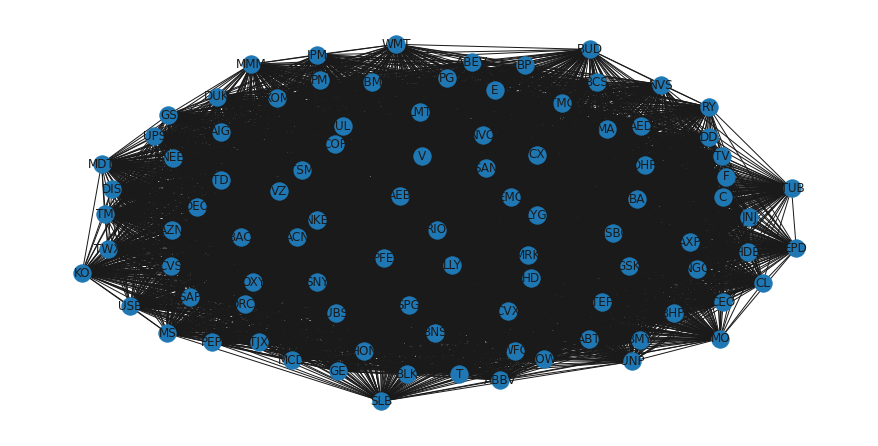

In [102]:
corr_network = nx.Graph()
list_of_comp = [keys for keys in diz_returns]
print(list_of_comp)

num_companies = len(diz_returns.keys())
print(num_companies)

for i1 in range(num_companies - 1):
    for i2 in range(i1 + 1, num_companies):
        # stock1 = diz_returns.keys()[i1]
        # stock2 = diz_returns.keys()[i2]
        stock1 = list_of_comp[i1]
        stock2 = list_of_comp[i2]

        # metric distance
        corr = stocks_corr_coeff(diz_returns[stock1], diz_returns[stock2])
        metric_distance = math.sqrt(2*(1.0 - corr))
        # building the network
        corr_network.add_edge(stock1, stock2, weight=metric_distance)

print("number of nodes:",corr_network.number_of_nodes())
print("number of edges:",corr_network.number_of_edges())
nx.draw(corr_network, with_labels=True)

## Minimum Spanning Tree with ([Prim's algorithm](http://en.wikipedia.org/wiki/Prim%27s_algorithm))

In [103]:
tree_seed = reference_company
N_new = []
E_new = []
N_new.append(tree_seed)

while len(N_new) < corr_network.number_of_nodes():
    min_weight = 10_000_000.0
    for n in N_new:
        for n_adj in corr_network.neighbors(n):
            if not n_adj in N_new:
                if corr_network[n][n_adj]['weight'] < min_weight:
                    min_weight = corr_network[n][n_adj]['weight']
                    min_weight_edge = (n,n_adj)
                    n_adj_ext = n_adj
    E_new.append(min_weight_edge)
    N_new.append(n_adj_ext)

# generate the tree from the edge list
tree_graph = nx.Graph()
tree_graph.add_edges_from(E_new)

# setting the color attributes for the network nodes
for n in tree_graph.nodes():
    tree_graph.nodes[n]['color'] = diz_colors[diz_sectors[n]]

## Printing the Financial Minimum Spanning Tree

<ipython-input-104-880d04d89b70>:1: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(


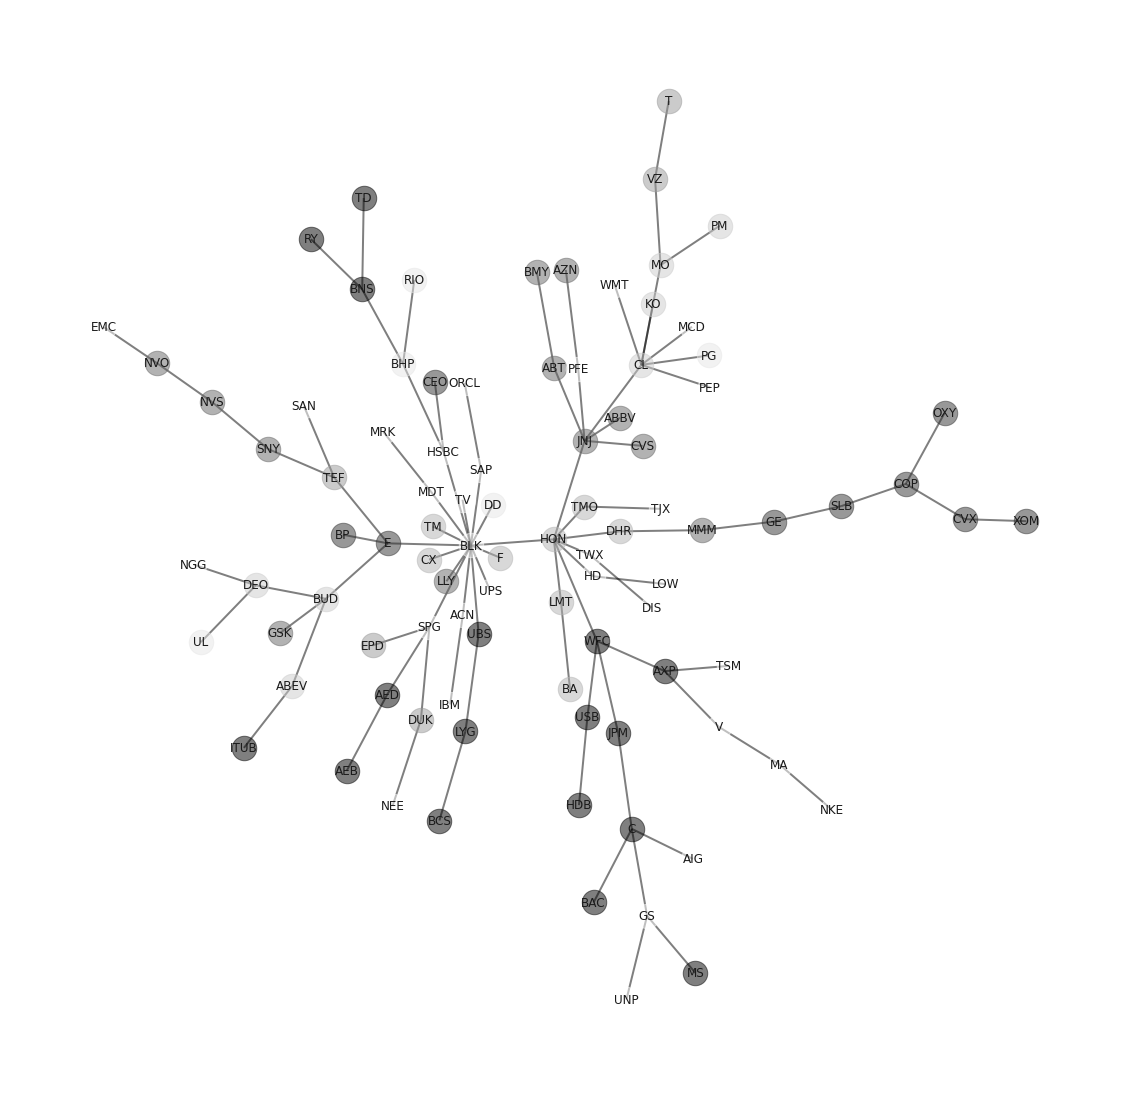

In [104]:
pos = graphviz_layout(
    tree_graph
    )

plt.figure(figsize=(20,20))
nx.draw_networkx_edges(
    tree_graph,
    pos,
    width=2, 
    edge_color='black', 
    alpha=0.5, 
    style="solid"
    )

nx.draw_networkx_labels(tree_graph, pos)
for n in tree_graph.nodes():
    nx.draw_networkx_nodes(
        tree_graph, pos, [n], node_size=600, alpha=0.5, 
        node_color=tree_graph.nodes[n]['color']
        )

plt.axis('off')
plt.savefig('MST_50B_new.png', dpi=600)